In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/challenger.csv')
df["temp"] = df["temp"] * 1.8 + 32 # 摂氏と華氏の変換
df

,flight,date,fail.field,fail.nozzle,temp
0,1,12/04/81,0,0,66.02
1,2,12/11/81,1,0,69.98
2,3,22/03/82,0,0,69.08
3,5,11/11/82,0,0,68.00
4,6,04/04/83,0,1,66.92
5,7,18/06/83,0,0,71.96
6,8,30/08/83,0,0,73.04
7,9,28/11/83,0,0,69.98
8,41-B,03/02/84,1,1,57.02
9,41-C,06/04/84,1,1,62.96


In [3]:
#説明変数 / 目的変数
N = len(df)
X = df["temp"].values
t = df["fail.field"].values

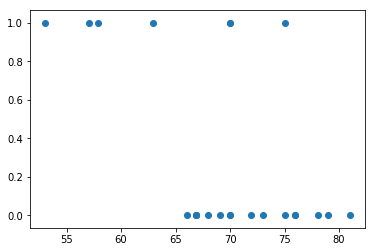

In [4]:
# 可視化
plt.scatter(X, t)
# そもそもこの1変数で説明すること自体に無理があるっぽい。

### 誤差逆伝播で計算

In [5]:
#各レイヤの定義
class Affine:
    def __init__(self, alpha, beta):
        self.params = [alpha, beta]
        self.grads = [np.zeros_like(alpha), np.zeros_like(beta)]        
    def forward(self, x):
        self.x = x
        alpha, beta = self.params
        return alpha * x + beta
    def backward(self, dout):
        alpha, beta = self.params
        self.dx = dout * alpha
        self.grads[0] = np.sum(dout*self.x, keepdims=True)
        self.grads[1] = np.sum(dout, keepdims=True)
        return self.grads
class Sigmoid:
    def __init__(self):
        self.params = [np.ones(1)]
        self.grads = [np.ones(1)]
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x)) 
        return self.y
    def backward(self, dout):
        return dout*self.y*(1-self.y)
class CrossEntropyError:
    def __init__(self):
        self.delta = 1e-7
        self.params = [np.ones(1)]
        self.grads = [np.ones(1)]
    def forward(self, y, t):
        self.y = y
        self.t = t
        return -np.dot(t, np.log(y + self.delta)) -np.dot(1-t, np.log(1-y + self.delta))
    def backward(self, dout=1):
        return -dout*self.t/self.y + dout*(1-self.t + self.delta)/(1-self.y + self.delta)

In [6]:
#optimizer
class Optimizer:
    def __init__(self, lr):
        self.lr = lr
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * np.array(grads[i])

In [7]:
#モデル構築
class LogisticRegression:
    def __init__(self):
        np.random.seed(1000) 
        alpha = np.random.randn(1)/10
        beta = np.random.randn(1)
        self.layers = [
            Affine(alpha,beta),
            Sigmoid()
        ]
        self.last_layer = CrossEntropyError()
        self.params = []
        self.grads = []
        for layer in self.layers:
            self.params.append(layer.params)
            self.grads.append(layer.params)
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
            #print(x)
        return x
    def forward(self, x, t):
        x = self.predict(x)
        loss = self.last_layer.forward(x,t)
        return loss
    def backward(self, dout=1):
        dout = self.last_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        for i,layer in enumerate(self.layers):
            self.grads[i] = layer.grads
        return dout
    def layer_params_update(self):
        for i,layer in enumerate(self.layers):
            layer.params = self.params[i]
    def gradient(self):
        return self.grads

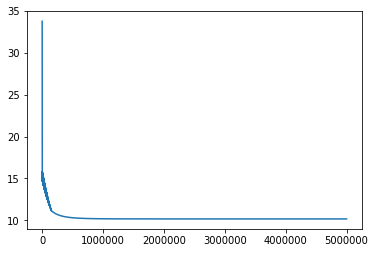

In [8]:
#学習
model = LogisticRegression()
optimizer = Optimizer(lr=0.0001)
loss_list = []
grads_list = []
for _ in range(5000000):
    loss = model.forward(X, t)
    grads = model.backward()
    optimizer.update(model.params, model.grads)
    model.layer_params_update()
    loss_list.append(loss)
    grads_list.append(model.grads)
plt.plot(range(len(loss_list)),loss_list)

In [9]:
#予測と正解の比較
print("予測")
print(np.round(model.predict(X), 2))
print(np.where(model.predict(X)>.5, 1, 0))
print("正解")
print(t)

予測
[0.43 0.23 0.27 0.32 0.38 0.16 0.13 0.23 0.86 0.6  0.23 0.04 0.38 0.94
 0.38 0.09 0.23 0.02 0.07 0.04 0.09 0.07 0.83]
[0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1]
正解
[0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1]


In [10]:
#パラメータ
model.params[0]

array([[-0.23145976],
       [14.99007259]])

## 数値微分によるチェック

In [11]:
#損失関数の定義
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.dot(t, np.log(y+delta))-np.dot(1-t, np.log(1-y+delta))
def loss(w, X, t):
    aff = np.dot(X, w)
    pred = sigmoid(aff)
    return cross_entropy_error(pred, t)

In [12]:
#説明変数、パラメータ
Xc = np.c_[X,np.ones(X.shape[0])]#説明変数 定数項として1を追加
w = np.ones(Xc.shape[1])/2#パラメータ
w = np.array([-0.4, 14.5])#初期値をいいところにおいてあげないと勾配が0になってしまってうまくいかない
grad = np.ones_like(w)#勾配の配列
print(Xc.shape)
print(w.shape)

(23, 2)
(2,)


In [13]:
cnts = 5000#000#計算回数
lr = 0.0001#学習率
h = 1e-5#数値微分時の微小変化

loss_list = []
for _ in range(cnts):
    #損失
    loss_ = loss(w, Xc, t)
    loss_list.append(loss_)
    #数値微分
    for i in range(w.shape[0]):
        tmp_val = w[i]
        w[i] = tmp_val + h
        fxh1 = loss(w, Xc, t)
        w[i] = tmp_val - h
        fxh2 = loss(w, Xc, t)
        grad[i] = (fxh1-fxh2)/(2*h)
        w[i] = tmp_val
    #パラメータ更新
    w -= lr * grad

Text(0, 0.5, 'loss')

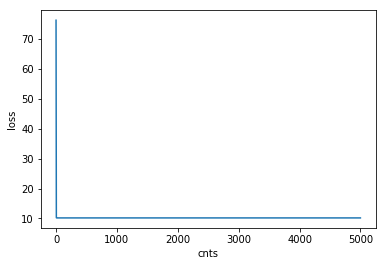

In [14]:
plt.plot(range(cnts), loss_list)
plt.xlabel("cnts")
plt.ylabel("loss")
#plt.ylim([0,150])
#plt.xlim([-20,100])

In [15]:
#パラメータ
w

array([-0.22439637, 14.50735975])